2025-01-31 08:43:40,446 - INFO - Found 131007 podcasts with listen score >= 30
2025-01-31 08:43:40,447 - INFO - Processing data in chunks...
2025-01-31 08:43:52,238 - INFO - Processed a chunk. Total podcasts accumulated: 6828
2025-01-31 08:43:52,409 - INFO - Processed a chunk. Total podcasts accumulated: 11296
2025-01-31 08:43:52,580 - INFO - Processed a chunk. Total podcasts accumulated: 14959
2025-01-31 08:43:52,745 - INFO - Processed a chunk. Total podcasts accumulated: 18063
2025-01-31 08:43:52,839 - INFO - Processed a chunk. Total podcasts accumulated: 20844
2025-01-31 08:43:53,007 - INFO - Processed a chunk. Total podcasts accumulated: 23336
2025-01-31 08:43:53,173 - INFO - Processed a chunk. Total podcasts accumulated: 25634
2025-01-31 08:43:53,337 - INFO - Processed a chunk. Total podcasts accumulated: 27771
2025-01-31 08:43:53,514 - INFO - Processed a chunk. Total podcasts accumulated: 29788
2025-01-31 08:43:53,685 - INFO - Processed a chunk. Total podcasts accumulated: 31694


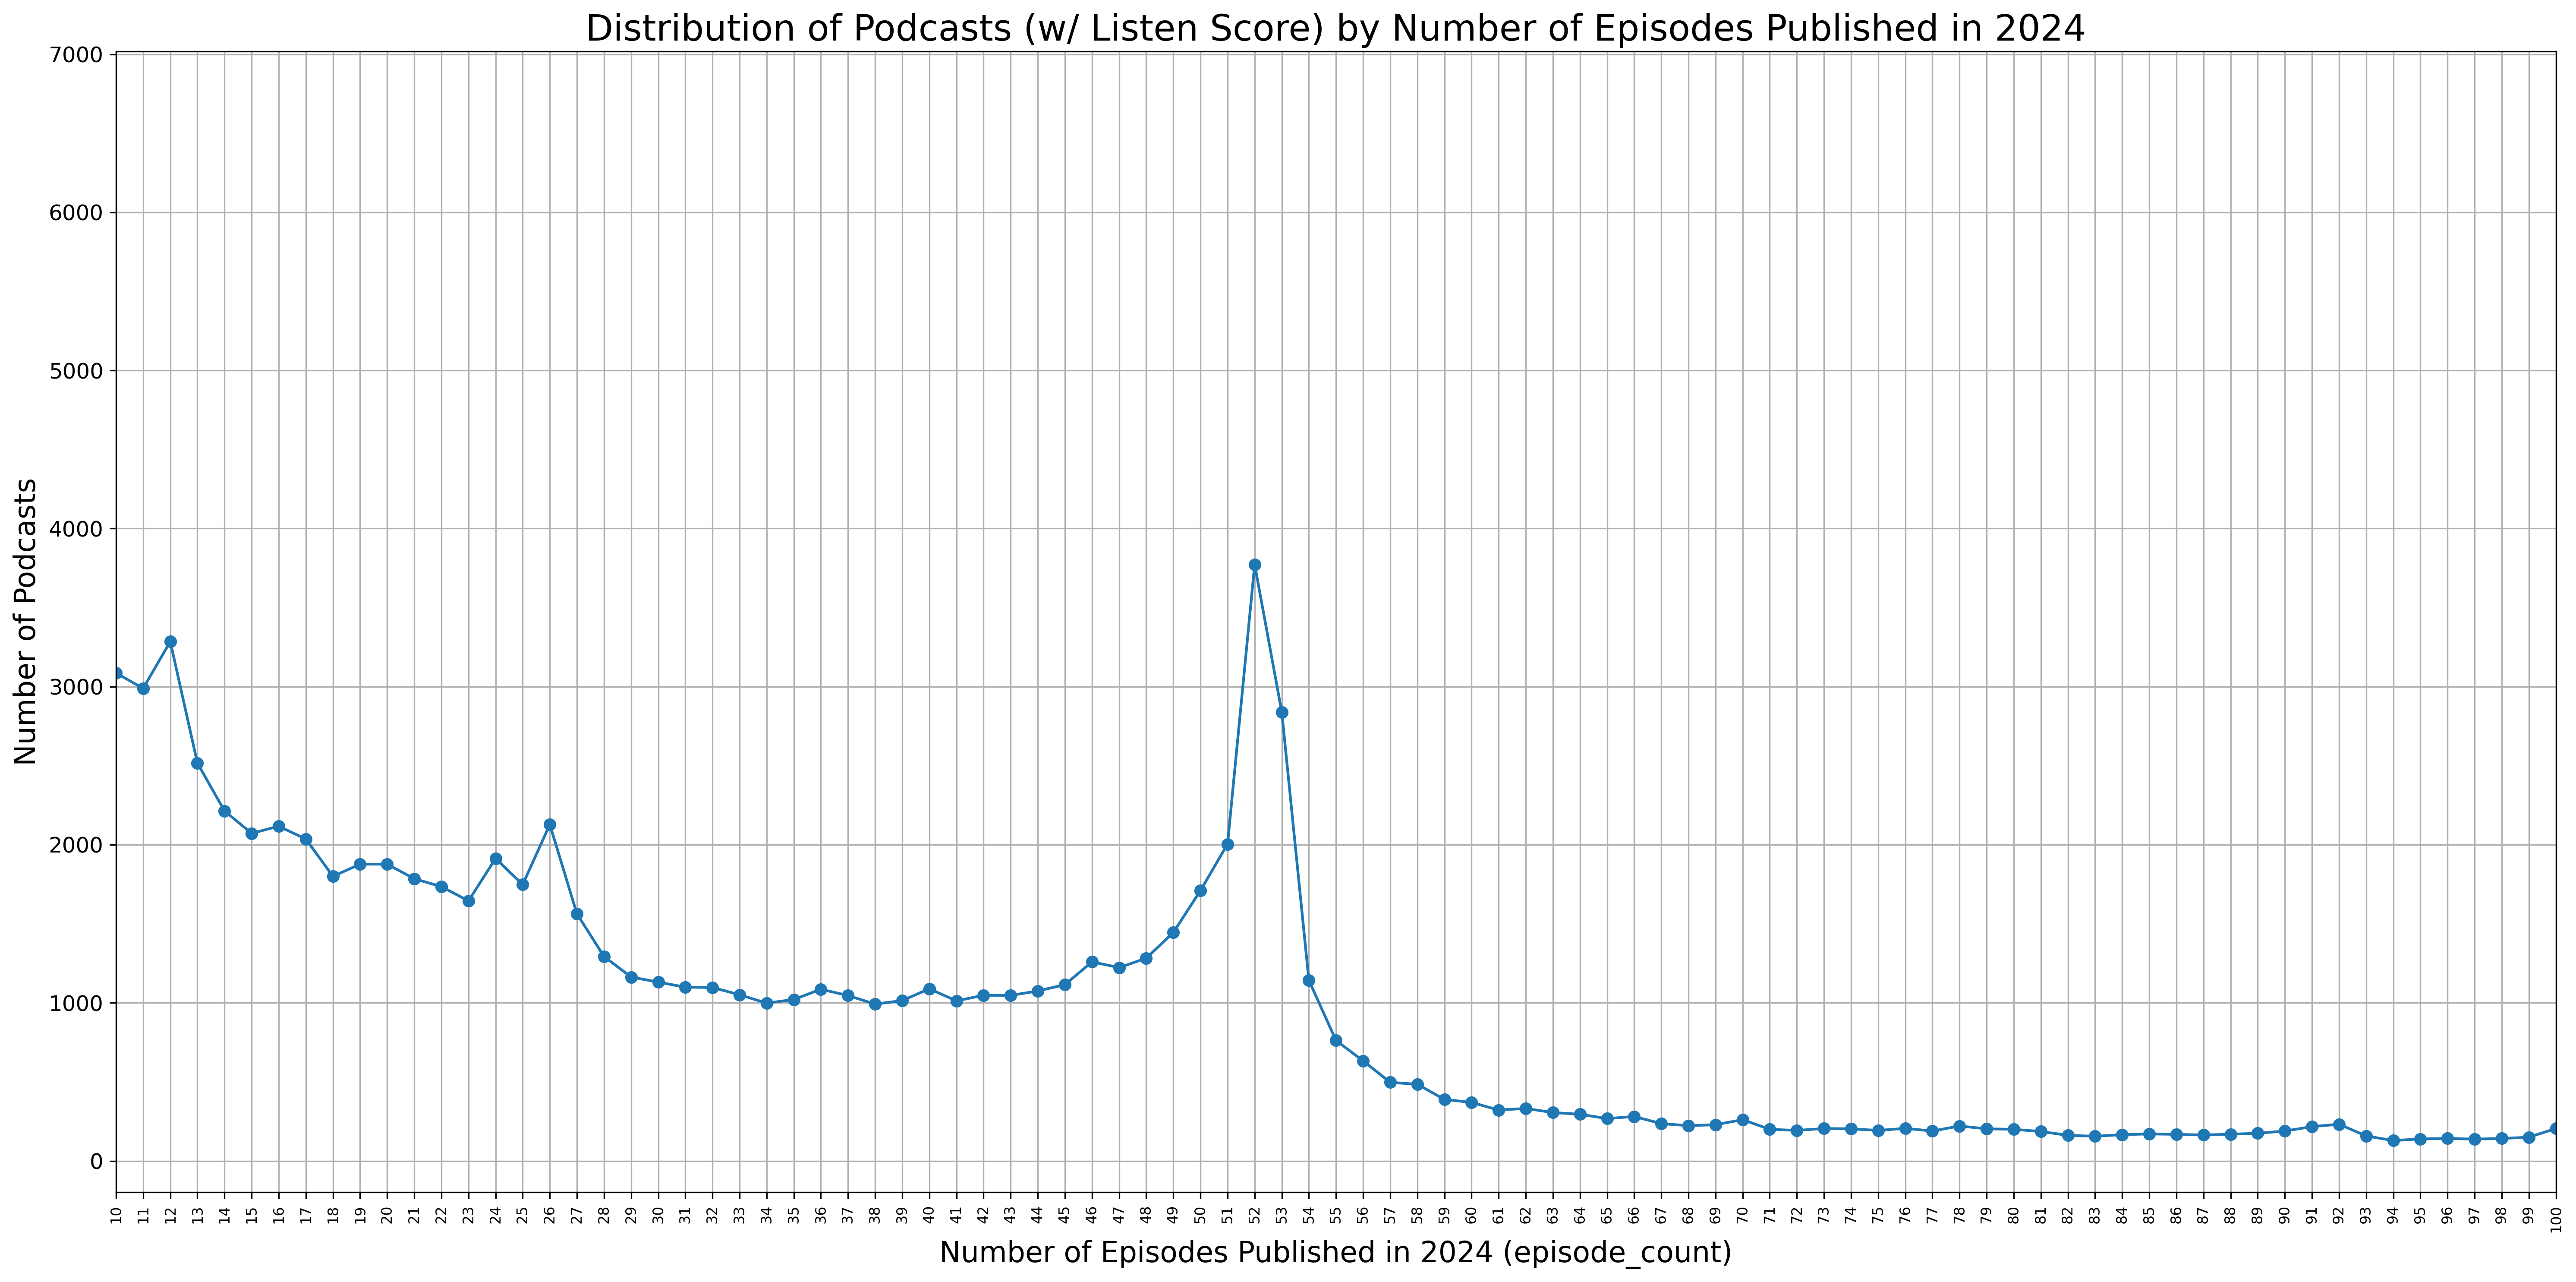

2025-01-31 08:44:39,642 - INFO - Line plot completed successfully.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database credentials
db_user = os.getenv('DB_USER', 'jcervantez')
db_password = os.getenv('DB_PASSWORD', 'Cervantez12')
db_host = os.getenv('DB_HOST', 'localhost')
db_port = os.getenv('DB_PORT', '5432')
db_name = os.getenv('DB_NAME', 'podcast_episodes')

# Check if database credentials are set
if not all([db_user, db_password]):
    logging.error("Database credentials are not fully set in the environment variables.")
    exit(1)

# Create the PostgreSQL database engine
engine = create_engine(
    f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}',
)

# Read the podcast_sample.csv file
try:
    podcast_samples = pd.read_csv('podcasts_even.csv', low_memory=False)
    # Filter podcasts with listen_score >= 30
    high_score_podcasts = podcast_samples[podcast_samples['listen_score'] >= 0]['podcast_id'].tolist()
    # Format the list of IDs with quotes for SQL
    quoted_ids = [f"'{id}'" for id in high_score_podcasts]
    logging.info(f"Found {len(high_score_podcasts)} podcasts with listen score >= 30")
except Exception as e:
    logging.error(f"Error reading podcast_sample.csv: {e}")
    exit(1)

# Define the chunksize for processing
chunksize = 100000
episode_counts = {}

try:
    logging.info("Processing data in chunks...")
    # SQL query to select episodes from podcasts with high listen scores
    sql_query = f"""
    SELECT podcast_id, episode_published 
    FROM podcasts_even 
    WHERE podcast_id IN ({','.join(quoted_ids)})
    """
    
    for chunk in pd.read_sql_query(sql_query, engine, chunksize=chunksize):
        # Parse the 'episode_published' column to datetime
        chunk['episode_published_parsed'] = pd.to_datetime(
            chunk['episode_published'], errors='coerce', utc=True
        )
        # Drop rows where date parsing failed
        chunk = chunk.dropna(subset=['episode_published_parsed'])
        # Filter episodes published in 2024
        chunk_2024 = chunk[chunk['episode_published_parsed'].dt.year == 2024]
        # Group by 'podcast_id' and count episodes per podcast in this chunk
        counts_chunk = chunk_2024.groupby('podcast_id').size()
        # Accumulate counts into the episode_counts dictionary
        for podcast_id, count in counts_chunk.items():
            episode_counts[podcast_id] = episode_counts.get(podcast_id, 0) + count
        logging.info(f"Processed a chunk. Total podcasts accumulated: {len(episode_counts)}")
except Exception as e:
    logging.error(f"Error processing data: {e}")
    exit(1)

# Convert the accumulated counts to a DataFrame
episode_counts_df = pd.DataFrame(list(episode_counts.items()), columns=['podcast_id', 'episode_count'])

# Compute the distribution
distribution = episode_counts_df['episode_count'].value_counts().reset_index()
distribution.columns = ['episode_count', 'number_of_podcasts']

# Create a DataFrame with all episode counts from 1 to 100
full_episode_counts = pd.DataFrame({'episode_count': np.arange(1, 101)})

# Merge with the distribution data
distribution_full = pd.merge(full_episode_counts, distribution, on='episode_count', how='left')
distribution_full['number_of_podcasts'] = distribution_full['number_of_podcasts'].fillna(0).astype(int)

# Plotting
try:
    logging.info("Plotting the distribution...")

    distribution_full = distribution_full.sort_values('episode_count')

    plt.figure(figsize=(20, 10), dpi=300)
    plt.plot(distribution_full['episode_count'], distribution_full['number_of_podcasts'], 
             marker='o', linestyle='-')

    plt.title('Distribution of Podcasts (w/ Listen Score) by Number of Episodes Published in 2024', 
             fontsize=20)
    plt.xlabel('Number of Episodes Published in 2024 (episode_count)', fontsize=16)
    plt.ylabel('Number of Podcasts', fontsize=16)
    plt.grid(True)
    plt.xlim(10, 100)
    plt.xticks(np.arange(10, 101, 1), fontsize=8, rotation=90)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    logging.info("Line plot completed successfully.")

except Exception as e:
    logging.error(f"Error during plotting: {e}")
    exit(1)


2025-01-28 11:36:36,386 - INFO - Loading CSV file from 'podcasts_sample.csv'...
C:\Users\jcerv\AppData\Local\Temp\ipykernel_104976\2599511387.py:29: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  podcasts_df = pd.read_csv(csv_file_path)
2025-01-28 11:36:37,816 - INFO - CSV file loaded successfully with 117527 records.
2025-01-28 11:36:37,834 - INFO - Dropped 64293 podcasts with null 'listen_score'.
2025-01-28 11:36:37,864 - INFO - After removing empty 'listen_score', 53234 podcasts remain.
2025-01-28 11:36:37,900 - INFO - Dropped 0 podcasts with invalid 'episode_count'.
2025-01-28 11:36:37,916 - INFO - Filtered podcasts to have 'episode_count' between 10 and 100.
2025-01-28 11:36:37,919 - INFO - Computed episode count distribution successfully.
2025-01-28 11:36:37,922 - INFO - Starting to plot the episode count distribution...


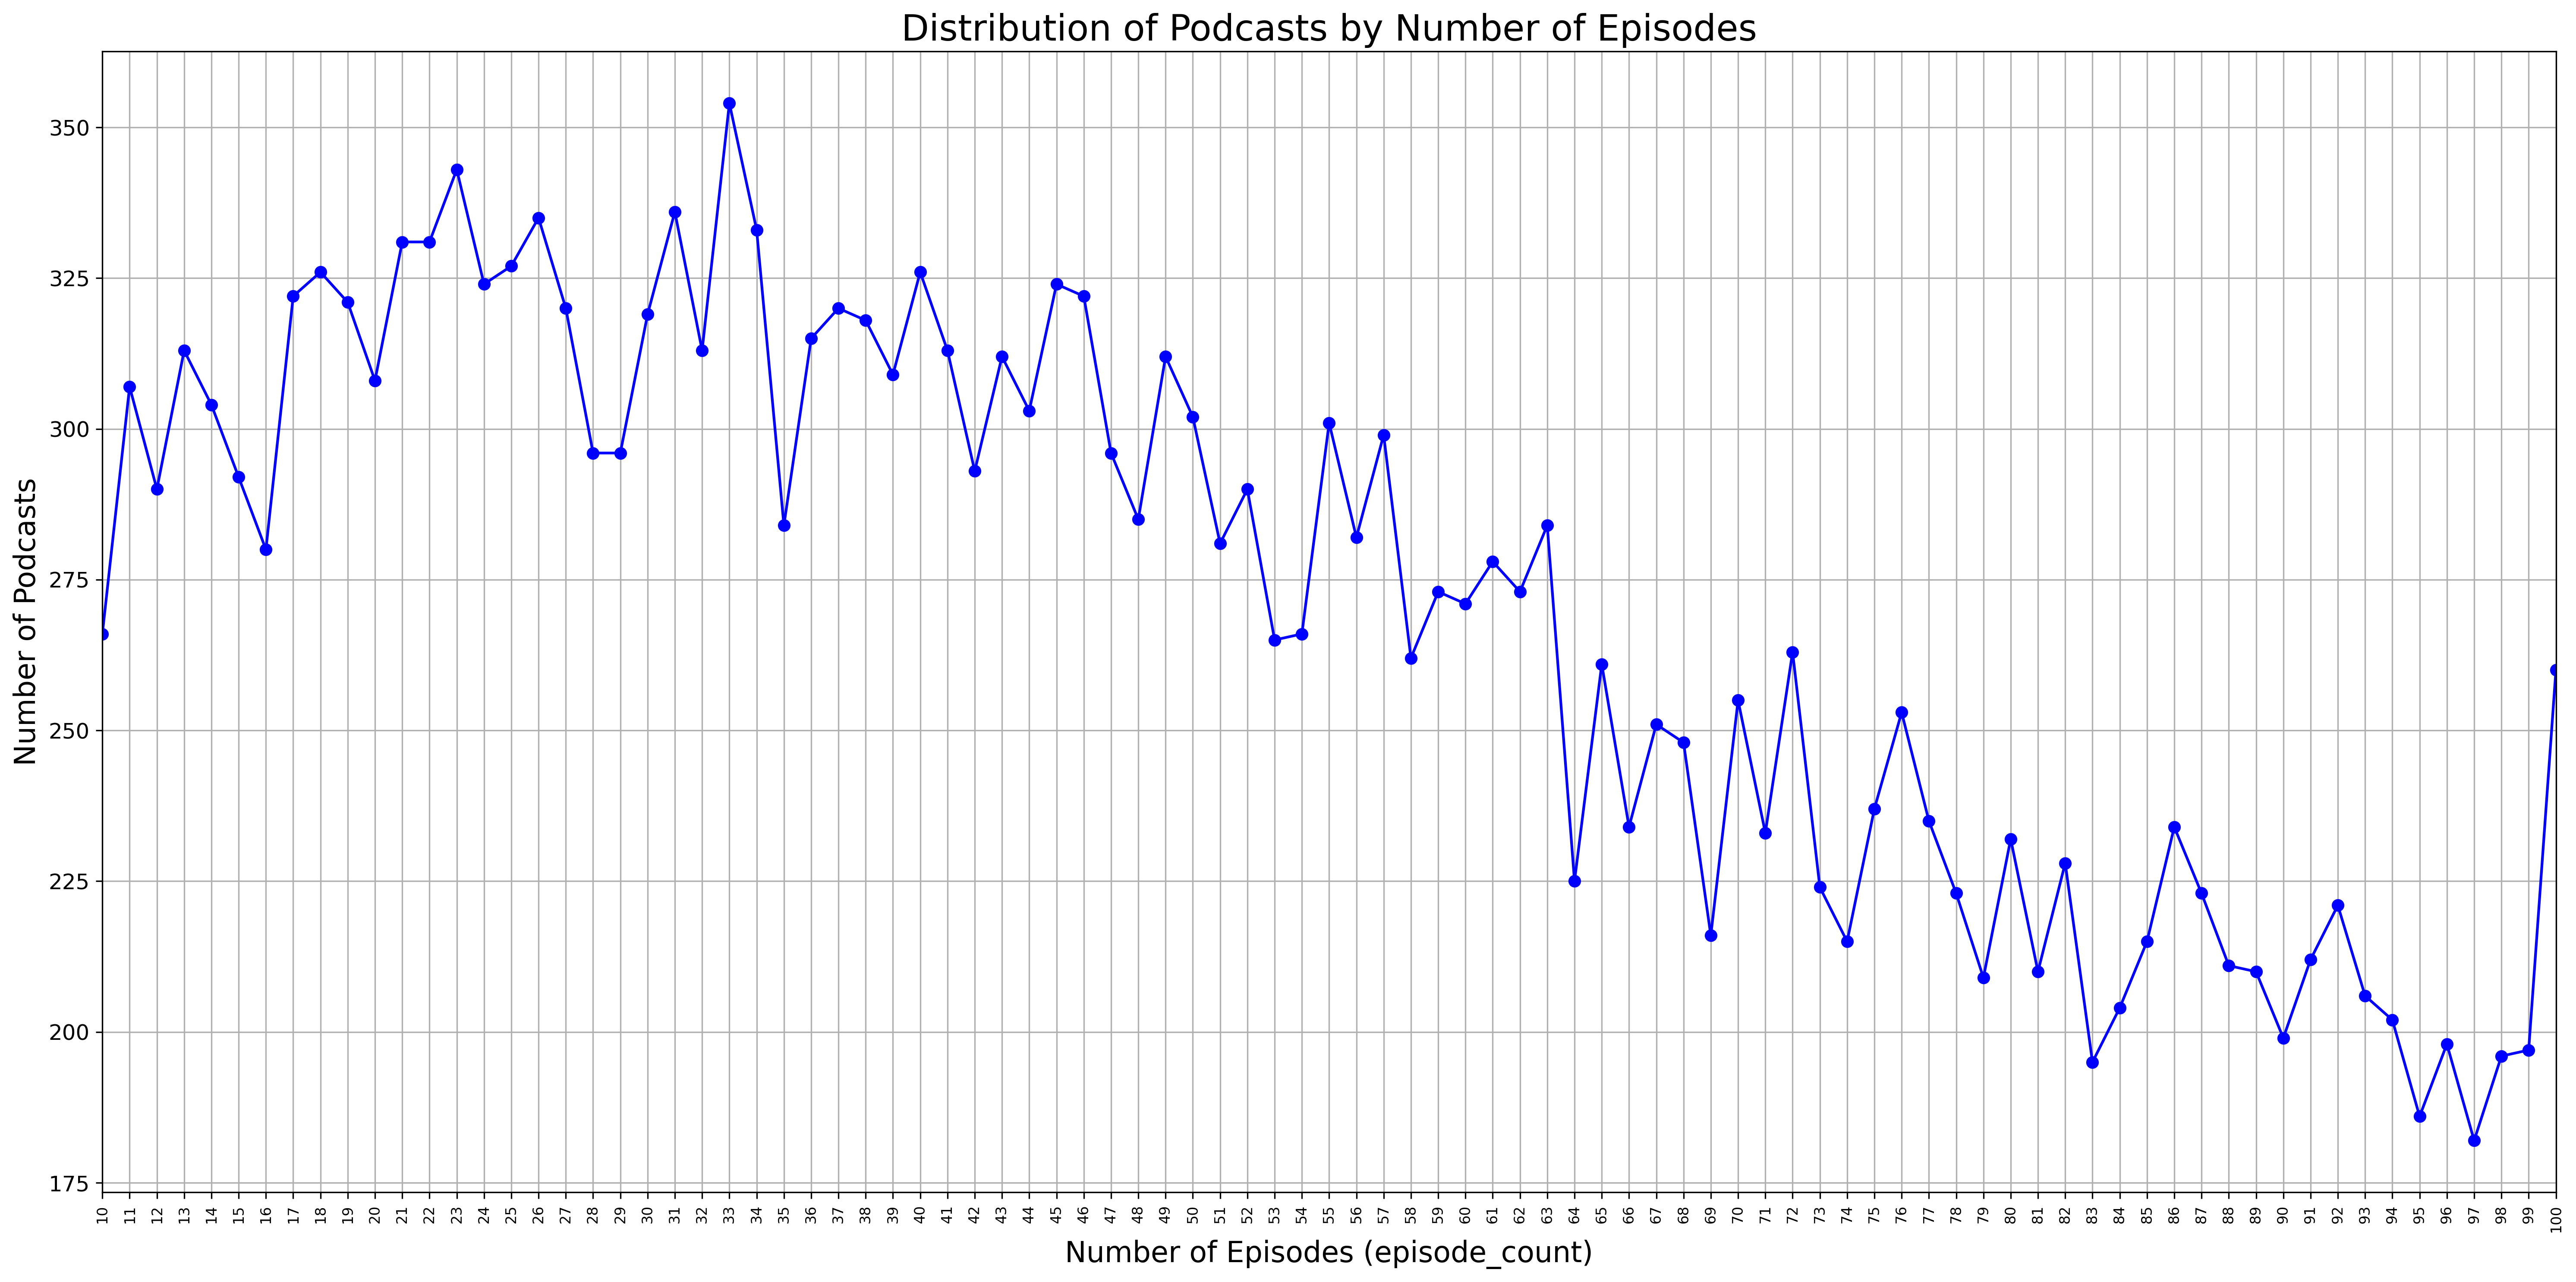

2025-01-28 11:36:38,648 - INFO - Line plot completed successfully.


In [12]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_filter_csv(csv_file_path):
    """
    Load the CSV file and filter out podcasts with empty or null listen_score.

    Parameters:
        csv_file_path (str): Path to the podcasts_sample.csv file.

    Returns:
        pd.DataFrame: Filtered DataFrame containing valid podcasts.
    """
    try:
        logging.info(f"Loading CSV file from '{csv_file_path}'...")

        if not os.path.exists(csv_file_path):
            logging.error(f"The CSV file '{csv_file_path}' does not exist.")
            sys.exit(1)

        # Read the CSV file
        podcasts_df = pd.read_csv(csv_file_path)
        logging.info(f"CSV file loaded successfully with {len(podcasts_df)} records.")

        # Check if required columns exist
        required_columns = {'listen_score', 'podcast_id', 'episode_count'}
        missing_columns = required_columns - set(podcasts_df.columns)
        if missing_columns:
            logging.error(f"The following required columns are missing from the CSV: {missing_columns}")
            sys.exit(1)

        # Drop rows where 'listen_score' is null
        podcasts_filtered = podcasts_df.dropna(subset=['listen_score'])
        logging.info(f"Dropped {len(podcasts_df) - len(podcasts_filtered)} podcasts with null 'listen_score'.")

        # Additionally, drop rows where 'listen_score' is an empty string or only whitespace
        podcasts_filtered = podcasts_filtered[~podcasts_filtered['listen_score'].astype(str).str.strip().eq("")]
        logging.info(f"After removing empty 'listen_score', {len(podcasts_filtered)} podcasts remain.")

        return podcasts_filtered

    except Exception as e:
        logging.error(f"Error loading or processing CSV file: {e}")
        sys.exit(1)

def compute_episode_distribution(podcasts_df, min_episode=10, max_episode=100):
    """
    Compute the distribution of episode counts.

    Parameters:
        podcasts_df (pd.DataFrame): DataFrame containing podcast data.
        min_episode (int): Minimum number of episodes to include in the distribution.
        max_episode (int): Maximum number of episodes to include in the distribution.

    Returns:
        pd.DataFrame: DataFrame with 'episode_count' and 'number_of_podcasts'.
    """
    try:
        # Ensure 'episode_count' is numeric
        podcasts_df['episode_count'] = pd.to_numeric(podcasts_df['episode_count'], errors='coerce')
        initial_count = len(podcasts_df)

        # Drop rows with invalid 'episode_count'
        podcasts_df = podcasts_df.dropna(subset=['episode_count'])
        logging.info(f"Dropped {initial_count - len(podcasts_df)} podcasts with invalid 'episode_count'.")

        # Convert 'episode_count' to integer
        podcasts_df['episode_count'] = podcasts_df['episode_count'].astype(int)

        # Filter episode counts to min_episode through max_episode
        podcasts_df = podcasts_df[podcasts_df['episode_count'].between(min_episode, max_episode)]
        logging.info(f"Filtered podcasts to have 'episode_count' between {min_episode} and {max_episode}.")

        # Compute the distribution
        distribution = podcasts_df['episode_count'].value_counts().reset_index()
        distribution.columns = ['episode_count', 'number_of_podcasts']

        # Ensure all episode counts from min_episode to max_episode are present
        full_episode_counts = pd.DataFrame({'episode_count': np.arange(min_episode, max_episode + 1)})
        distribution_full = pd.merge(full_episode_counts, distribution, on='episode_count', how='left')
        distribution_full['number_of_podcasts'] = distribution_full['number_of_podcasts'].fillna(0).astype(int)

        logging.info("Computed episode count distribution successfully.")

        return distribution_full

    except Exception as e:
        logging.error(f"Error computing episode distribution: {e}")
        sys.exit(1)

def plot_episode_distribution(distribution_df, min_episode=10, max_episode=100):
    """
    Plot the distribution of episode counts as a line plot.

    Parameters:
        distribution_df (pd.DataFrame): DataFrame with 'episode_count' and 'number_of_podcasts'.
        min_episode (int): Minimum number of episodes displayed on the x-axis.
        max_episode (int): Maximum number of episodes displayed on the x-axis.
    """
    try:
            logging.info("Starting to plot the episode count distribution...")

            # Ensure the data is sorted by 'episode_count'
            distribution_df = distribution_df.sort_values('episode_count')

            plt.figure(figsize=(20, 10), dpi=300)  # High resolution

            plt.plot(
                distribution_df['episode_count'],
                distribution_df['number_of_podcasts'],
                marker='o',
                linestyle='-',
                color='blue'
            )

            plt.title('Distribution of Podcasts by Number of Episodes', fontsize=20)
            plt.xlabel('Number of Episodes (episode_count)', fontsize=16)
            plt.ylabel('Number of Podcasts', fontsize=16)
            plt.grid(True)
            plt.xlim(min_episode, max_episode)  # Adjust x-axis limits to start from min_episode

            # Set x-ticks to every 1 unit from min_episode to max_episode
            plt.xticks(np.arange(min_episode, max_episode + 1, 1), fontsize=8, rotation=90)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()
            logging.info("Line plot completed successfully.")

    except Exception as e:
            logging.error(f"Error during plotting: {e}")
            sys.exit(1)

def main():
    # Define the path to the CSV file
    csv_file_path = 'podcasts_sample.csv'  # Adjust the path if necessary

    # Load and filter the CSV data
    podcasts_filtered = load_and_filter_csv(csv_file_path)

    # Compute the episode count distribution with minimum episodes set to 10
    distribution_df = compute_episode_distribution(podcasts_filtered, min_episode=10, max_episode=100)

    # Plot the distribution as a line plot
    plot_episode_distribution(distribution_df, min_episode=10, max_episode=100)

if __name__ == "__main__":
    main()
